# Out-of-memory classification of the EMNIST dataset
In this notebook we focus on a simple binary classification problem with a standard image dataset, but we put some attention on the interplay between `dask` and `keras` to enable processing datasets potentially larger than the available memory. 

## Problem statement
Considering a dataset of handwritten digits, we will try to identify those representing a digit other than zero (or non-zero, that we will call *signal*) from those representing a *zero* (that we will call our *background*).

## Dataset 
To make things a bit more spicy 🌶️ we will use an extended version of MNIST (named [EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset)), a very large set of handwritten digits derived from the NIST Special Database 19 and converted to 28x28 pixel images.

Further information on the dataset contents and conversion process are available in [dedicated paper on arXiv](https://arxiv.org/abs/1702.05373v1).  

To make it easier to download the dataset, we will rely on the `tensorflow_dataset` package available on PyPI and providing a simplified interface to download this large dataset from remote repositories. 

In [1]:
!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm

emnist = tfds.load('mnist', split='train', as_supervised=True)

all_images = np.array([image for image, _ in tqdm(tfds.as_numpy(emnist), desc="Repacking images to numpy")]).reshape((-1, 28, 28))
all_labels = np.array([label for _, label in tqdm(tfds.as_numpy(emnist), desc="Repacking labels to numpy")])

print ("Shape of the image:", all_images.shape)

2024-12-03 09:25:04.359284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 09:25:04.399980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 09:25:04.400029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 09:25:04.400053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 09:25:04.406834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 09:25:04.408143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Shape of the image: (60000, 28, 28)


## Libraries used 📚
 
Beyond the omnipresent numpy and pyplot modules, we will be using
 * *tensorflow* (via its keras interface) for developing, training, storing and evaluating Deep Neural Networks;
 * *dask.array* to support out-of-memory computations.

We will also use the `tqdm` module to represent nice progress bars.

In [2]:
## Numerical python
import numpy as np 

## Plotting 
import matplotlib.pyplot as plt

## Tensorflow for machine learning
import tensorflow as tf

## Dask for out-of-memory pipelines
import dask.array as da

## Progress bar
from tqdm import trange 

## Visualizing some sample of the dataset 👀

As mentioned above, the dataset is composed of 28x28 monochromatic images.
Each pixel is associated to a single 8-bit value (ranging from 0 to 255) representing its brightness.

If drawn in gray scale the digits appear white on a black background.

uint8 (60000, 28, 28)


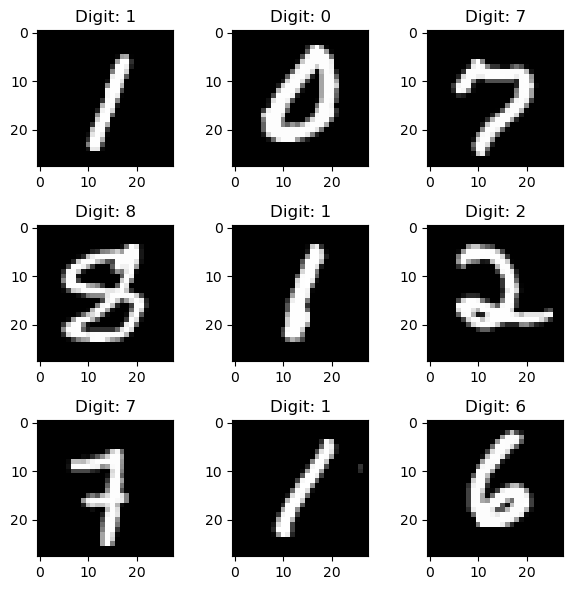

In [3]:
print (all_images.dtype, all_images.shape)

plt.figure(figsize=(6, 6))
for iPlot in range(1, 10):
    plt.subplot(3, 3, iPlot)
    plt.imshow(all_images[iPlot], cmap='gray')
    plt.title(f"Digit: {all_labels[iPlot]}")

plt.tight_layout()

## Preparation of the training 🏋️ and validation 🕵️ datasets

While developing a model and testing its ability to learn from data it is of crucial importance to monitor its ability of generalizing as well.

Having a model capable of distinguishing perfectly from signal from background in the training sample is rather simple: it would be sufficient to memorize in a big table the input variables and the label (look-up table approach), but that would generalize rather poorly to entries not stored in the table. 

To ensure the model is capable of generalizing to an independent model, we will just pick a sample of the dataset and, from time to time during the training, we will check that the performance on the training sample is not too different from that on the test dataset.

For simplcity, we can pick the first 1000 images (and their associated labels) and remove them from the training dataset, using them uniquely for validation.

In [4]:
n_validation = 1000

validation_images = all_images[:n_validation]
training_images = all_images[n_validation:]

validation_labels = all_labels[:n_validation]
training_labels = all_labels[n_validation:]

## Preparing the pipeline and define the batch size (🪣 or 🍸?)

Now, the EMNIST dataset is large, but with the wonderful machines you are entitled to use in this school, you would be able to process them in one go. But in general this might not be true, and the dataset you would need to process may be larger than the RAM memory made available to your process.

In this case you need to split the processing in batches or chunkes and perform each operation sequentially on each batch. So having small batches is good because it ease using smaller memory (which usually means the processor is capable of exploiting the fastest part of the RAM).

On the other hand, switching from one batch to another is expensive, so having large batches is also good. 

The optimal trade off between the RAM needed to perform a computation and the speed gain obtained from effective parallelization of the elements in the batch depends on the architecture and on the machine you can use.

In addition when discussing of the training of machine learning algorithms, often the discussion on the batch size for an out-of-memory pipeline gets mixed with the batches used for stochastic gradient descents. 

In other words, Machine Learning algorithms are often by updating the weights based on an evaluation of the loss function obtained with a subset of the whole dataset. 
This enables a much faster estimate (but less precise) estimate of the gradients and therefore enables faster training. 

The precision on the gradients scales as the square root of the number of elements in the batch, 
while the time to compute the gradients scales as the number of elements in the batch, so one may conclude that the optimal training would be obtained with tiny batches. In practice, this is just another reason to favour small batches over large ones. But if the batches become too small, the computation becomes inefficient.

In practice... it depends.

Here, after some minimal tuning, we chose a `batch_size`, common for the out-of-memory computation and for tensorflow, of 6000 images. 

Feel free to tune it!

In [5]:
## Batch size
batch_size = 6000

Then, before we feed our Neural Network with the images we need to:
 * convert the numpy array in a dask array defining the chunk size to enable computations one chunk at once;
 * make sure we pass floating point numbers of the order of 1, rather than integers in the range $[0, 255]$.

To highlight the symmetry between the processing of a dask array and a numpy array, we will transform into dask array only the fraction of images used for the training, while the thousand images reserved for validation are treated as a plain numpy array. 

The preprocessing steps highlighted above are implemented with the exact same syntax on the two.

Finally, dask will provide us with size of the array after the preprocessing and with the size of the single chunk.


In [6]:
## Acquisition of the numpy array in dask
dask_training_images = da.from_array(training_images, chunks=(batch_size, -1, -1))

## Preprocessing *pipeline* in dask (for training)
dask_training_pp_images = dask_training_images.astype(np.float32)/255.

## Preprocessing operation in numpy (for validation)
validation_pp_images = validation_images.astype(np.float32)/255.

display(dask_training_pp_images)

dask.array<truediv, shape=(59000, 28, 28), dtype=float32, chunksize=(6000, 28, 28), chunktype=numpy.ndarray>

The preprocessing of the labels is even simpler: we convert the digit provided by the MNIST dataset as a lable into boolean, `true` if the digit is non-zero, or `false` otherwise.



In [7]:
## Preprocessing pipeline in dask
dask_training_labels = da.from_array(training_labels, chunks=(batch_size,))

## Preprocessing operation in numpy.astype(np.float32)

## Preprocessing of the labels
dask_training_pp_labels = (dask_training_labels > 0)
validation_pp_labels = (validation_labels > 0)

display(dask_training_pp_labels)

dask.array<gt, shape=(59000,), dtype=bool, chunksize=(6000,), chunktype=numpy.ndarray>

## Intermezzo: TensorFlow and Keras

😍 Fantastic! We have our input features prepared in dask and ready to be piped in a Convolutional Neural Network performing a classification task.

Before diving in Convolutional Neural Networks, though, it might be useful to review the basics of TensorFlow and of Deep Neural Networks.

Let's start by introducing TensorFlow.

TensorFlow is a framework that lets you do amazing things with machine learning and artificial intelligence. 
It was made by Google, but it is today an Open Source project.

Autograd is a feature of TensorFlow that allows you to automatically compute the gradients of multidimensional arrays (or *tensors* in ML jargon) involved in differentiable operations. 

It is very useful for optmization tasks, such as training neural networks, as it simplifies the calculation of the gradient of the loss function with respect to the parameters defining the algorithm, reaching the minimum quickly 🎯

Autograd works by keeping track of the operations performed on tensors and then appying the chain rule to compute the derivatives when needed. 

The importance of Autograd for training neural networks cannot be overestimated! To approximate the *gradient* of a function with a finite difference techniques, you would need to evaluate the function at least once per variable. If the evaluation of the function is slow (as in the case of a deep neural network), that method become unusable. By computing the derivative analytically, one can evaluate the loss function and its gradient in one single evaluation.



### Least-squared method in TensorFlow

Before introducing neural networks, let's focus a very basic problem and try to solve it in TensorFlow. 

Consider for example a fit with the least-squared method.

We take a randomly generated dataset obtained by sampling a standard normal distribution, we use it to fill a histogram and we try to fit a normal distribution to it.

In steps we wish to:
 * generate a random sample distributed as a standard Gaussian;
 * fill a histogram with the generated sample;
 * fit a Gaussian to the histogram using the least-squared method.

🎲🎲 Let's start with generating the dataset, say $r$, with mean equal to 0 and standard deviation equal to 1. 

Let's generate 100 data points.


In [8]:
r = np.random.normal(0, 1, 100)

📊 Then we fill a histogram. Let's consider a histogram with it.
We will use a histogram of 100 bins spanning from -5 to 5.

We will denote by $x_i$ the center of the $i$-th bin, and by $c_i$ its ***normalized content*** (note that the normalization requires the *integral* and not the *sum* to be one).

And then we superpose the expected distribution:
$$
f_g(x; \mu=0, \sigma=1) \quad = \quad \frac{1}{\sqrt{2\pi}\,\sigma}\exp\left(-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right) \quad = \quad 
\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}x^2\right)
$$


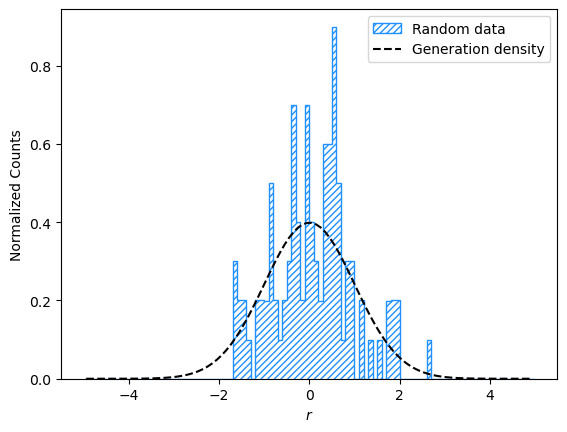

In [9]:
## We define and fill the histogram
contents, bin_boundaries, _ = plt.hist(
    r, 
    bins=100, 
    range=(-5, 5), 
    density=True, 
    label="Random data", 
    hatch='/////', 
    histtype='step', 
    edgecolor='dodgerblue'
)
## Given the boundaries, we compute the center x_i of each bin 
xAxis = 0.5*(bin_boundaries[:-1] + bin_boundaries[1:])

## We define a generic Gaussian function
def gaussian(x, mean, sigma):
    z = (x - mean)/sigma
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5 * z**2)

## We plot the Gaussian distribution as defined in the function above
plt.plot(xAxis, gaussian(xAxis, 0, 1), 'k--', label="Generation density")

## ... cosmetics ...
plt.xlabel("$r$")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

#### Recap of the least-squared method

The least-squared method is a method to obtain estimators in statistics derived from the maximum likelihood principle by assuming that all the involved distributions are normal.

In practice, we first a function $\chi^2$ of the parameters to be estimated (mean and standard deviation, in our case) as 
$$
\chi^2 (\mu, \sigma) = \sum_i \frac{(c_i - \mathcal N(x_i; \mu, \sigma))^2}{\mathcal N(x_i; \mu, \sigma)}
$$
where $\mathcal N(x; \mu, \sigma)$ denotes the value of the Gaussian distribution evaluated in the point $x$ for a given value of $\mu$ and $\sigma$.

And then we obtain estimators for the mean and the standard deviation as those values minimizing the $\chi^2$. Namely,
$$
\hat \mu, \hat \sigma = \mathop{\rm argmin}_{\mu, \sigma} \chi^2(\mu, \sigma)
$$

Let's see how to setup such a minimization using autograd in TensorFlow.

While reading the code below focus your attention of the following steps:
 * ⚽ we define the variables ***and their initialization values***  (mean and standard deviation);
 * ⛹️ we define the model (a Gaussian);
 * 🥅 we define the loss function to guide the optimization (the $\chi^2$);
 * 🌠 we define an optimizer, representing a technique to descend the gradient (for example "ADAM") and the *learning rate* measuring the allowed leap for each single step;
 * 💫 we define the optimization loop, for each iteration we compute the gradients and update the variables based on the receipt provided by the optimizer.

In [10]:
## Define the mean and the standard deviation as a free variable.
## Takes the mean and the standard deviation of the original dataset (before histogramming) to initialize the values 
mean = tf.Variable(float(np.mean(r)), name="Mean")
sigma = tf.Variable(float(np.std(r)), name="Std")

## Define the fit function, not that the dependence on the free variables is implicit
def fitfun(x):
    z = (x - mean)/sigma
    return 1/tf.sqrt(2*np.pi)/sigma * tf.exp(-0.5 * z**2)

## Define the chi2 function
def chi2():
    predicted_contents = fitfun(xAxis)
    return tf.reduce_sum((contents - predicted_contents)**2 / predicted_contents)

## Define an optimization technique, consider this as the machine-learning black magic
learning_rate = 1e-1
optimizer = tf.keras.optimizers.Adam(learning_rate)

## Optimization loop
losses = []   ## <-- we will store the value of the chi2 at each iteration (epoch) in this list
mean_and_sigma = []  ## <-- and the mean and the sigma after each update here
for epoch in range(50):  ## <-- we iterate for several times (that's why we call it a loop)
    grad = optimizer.compute_gradients(chi2, var_list=[mean, sigma])  ## <-- we compute the gradients with autograd
    optimizer.apply_gradients(grad) ## <-- we update the variables mean and sigma descending the gradient
    ## note the that .compute_gradients + .apply_gradients  =  .minimize

    ## We store the results of this step in the lists defined above
    mean_and_sigma.append((mean.numpy(), sigma.numpy())) 
    losses.append (chi2().numpy())


Let's represent somehow the progression of the optimization.

> 💡 **Hint.** Play with the learning rate, or change optimizer, to see how the path is affected.

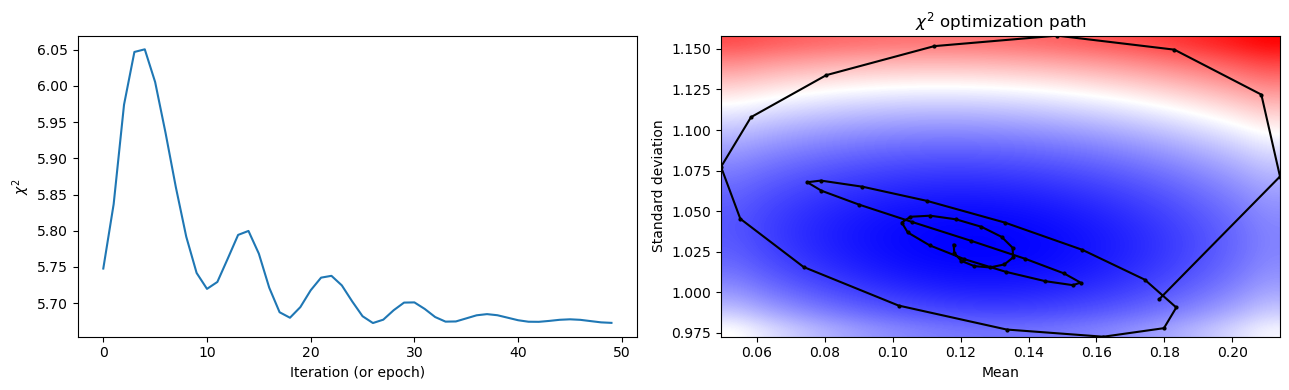

In [11]:
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel("Iteration (or epoch)")
plt.ylabel("$\chi^2$")

plt.subplot(1, 2, 2)
np_mean, np_sigma = np.array(mean_and_sigma).T
plt.plot(np_mean, np_sigma, 'ko-', markersize=2)

np_chi2 = []
for mean_ in np.linspace(np_mean.min(), np_mean.max(), 21):
    for sigma_ in np.linspace(np_sigma.min(), np_sigma.max(), 21):
        mean.assign(mean_)
        sigma.assign(sigma_)
        np_chi2.append(chi2().numpy())
    
plt.imshow(
    np.array(np_chi2).reshape((21, 21)).T, 
    origin='lower', 
    extent=(np_mean.min(), np_mean.max(), np_sigma.min(), np_sigma.max()), 
    cmap='bwr', 
    interpolation='bicubic',
    aspect='auto',
)
plt.xlabel("Mean")
plt.ylabel("Standard deviation")
plt.title("$\chi^2$ optimization path")

plt.tight_layout()

And conclude by superposing the optimized Gaussian function to the histogram to see how different it is from the ideal one.

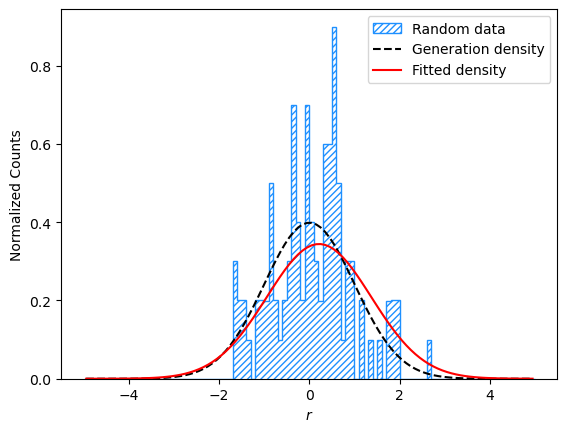

In [12]:
plt.hist(r, bins=np.linspace(-5, 5, 101), density=True, label="Random data", hatch='/////', histtype='step', edgecolor='dodgerblue')
plt.plot(xAxis, gaussian(xAxis, 0, 1), 'k--', label="Generation density")
plt.plot(xAxis, gaussian(xAxis, mean.numpy(), sigma.numpy()), 'r-', label="Fitted density")

plt.xlabel("$r$")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

### Keras

The [keras library](https://keras.io/api/optimizers/) provides a set of very well designed classes and functions to go through the five steps enumerated above for standard (and less standard) deep learning tasks.

Let's get started with a minimalistic example. Let's try to fit our histogram with the function
$$
f(x; a_0, a_1) = \left\{
\begin{array}{ll}
  a_0 + a_1 x \qquad & \mbox{for}\ (a_0 + a_1 x) > 0 \\
  0 &  \mbox{otherwise}
\end{array}
\right.
$$

We will create a "Sequential" model, describing models where a sequence of layers are applied one after the other to the input to provide an output.

But we will use a single Dense layer, with 1 input and 1 output and as activation function we will use a Rectified Linear Unit (ReLU).

We will use a Mean Squared Error loss function which is very similar to a $\chi^2$, but it neglets the errors and sets all the denominators to 1.

While looking through the following minimal example, make sure you recognize the five steps listed above:
 * ⚽ we define the variables ***and their initialization values***  (our `Dense` layer has a `kernel` and a `bias` representing $a_1$ and $a_0$, respectively);
 * ⛹️ we define the model (a *Sequential* model with a single Dense layer having "relu" activation);
 * 🥅 we define the loss function to guide the optimization (the "mse", *Mean Squared Error*);
 * 🌠 we define an optimizer, representing a technique to descend the gradient (for example "ADAM") and the *learning rate* measuring the allowed leap for each single step;
 * 💫 we define the optimization loop, for each iteration we compute the gradients and update the variables based on the receipt provided by the optimizer (done internally to `fit`).

In [13]:
## We create a single Dense layer with output 1 
dense_layer = tf.keras.layers.Dense(1, activation='relu', kernel_initializer="zeros", bias_initializer=tf.keras.initializers.Constant(0.3))

## We create the model as a Sequential model
model = tf.keras.models.Sequential([ dense_layer ])

## We define the input size of the model, in this case it will take 1 feature as input 
model.build(input_shape=(None, 1)) ## (None stands for "any number of entries can be processed in a batch")

## We print the weights: the kernel (corresponding to a_1) and the bias (corresponding to a_0) and their initial values
print (dense_layer.weights)

## We define an optimizer and a loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

## We lauch the training loop (np.c_ converts an array in a single-column matrix)
keras_out = model.fit(np.c_[xAxis], np.c_[contents], epochs=20, verbose=False)

## Print the summary
model.summary()

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.3], dtype=float32)>]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As before, let's draw the evolution of the training and the resulting function.

4/4 [==============================] - 0s 1ms/step


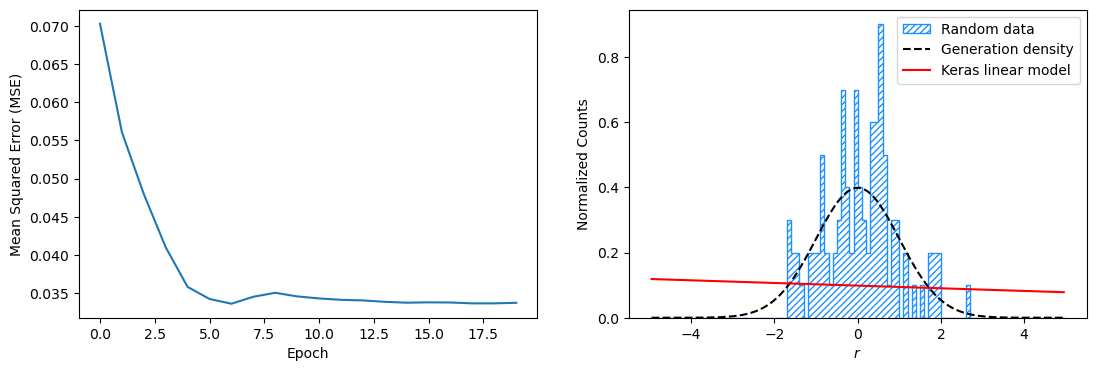

In [14]:
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)
plt.plot(keras_out.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")


plt.subplot(1, 2, 2)
plt.hist(r, bins=np.linspace(-5, 5, 101), density=True, label="Random data", hatch='/////', histtype='step', edgecolor='dodgerblue')
plt.plot(xAxis, gaussian(xAxis, 0, 1), 'k--', label="Generation density")
plt.plot(xAxis, model.predict(np.c_[xAxis]).flatten(), 'r-', label="Keras linear model")

plt.xlabel("$r$")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

### Going deep

Now adding dense layers with different dimensionality is a trivial task 🥞
.
For example, below we add a couple of dense layer with 32 output node and hyperbolic tangent activation.

In [15]:
model_32_32 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_32_32.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
keras_out = model_32_32.fit(np.c_[xAxis], np.c_[contents], epochs=500, verbose=False)
model_32_32.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                64        
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


And we compare the optimized value with the original distribution. 

That's rather easy, no?

4/4 [==============================] - 0s 1ms/step


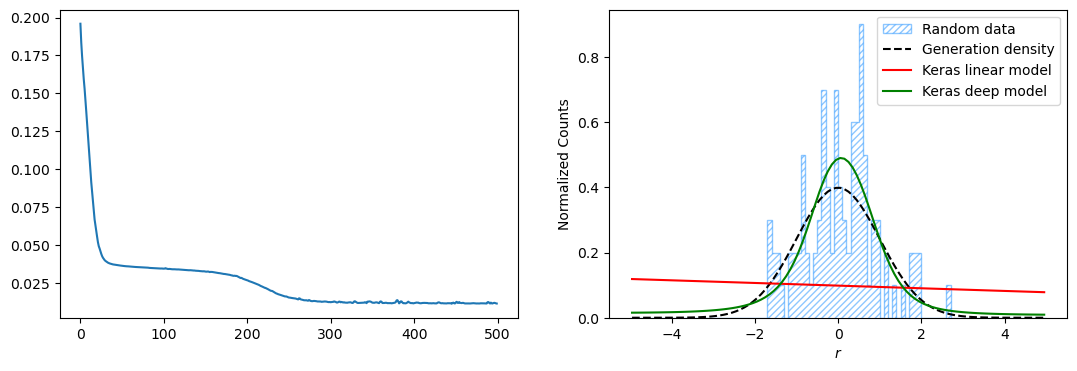

In [16]:
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)
plt.plot(keras_out.history['loss'])

plt.subplot(1, 2, 2)
plt.hist(r, bins=np.linspace(-5, 5, 101), density=True, label="Random data", hatch='/////', histtype='step', edgecolor='dodgerblue', alpha=0.5)
plt.plot(xAxis, gaussian(xAxis, 0, 1), 'k--', label="Generation density")
plt.plot(xAxis, model.predict(np.c_[xAxis]).flatten(), 'r-', label="Keras linear model")
plt.plot(xAxis, model_32_32.predict(np.c_[xAxis]).flatten(), 'g-', label="Keras deep model")

plt.xlabel("$r$")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

## Training a CNN for a binary classification task
### Preprocessed training and validation samples

Let' restart with out example, by renaming the training and validation data and labels with a standard notation.

$X$ represent the set of ***input features***, in this case the normalized pixel values of the images, anf $y$ the labels or the ***ground-truth***.

In [17]:
## Definition of the X tensor (input of the NN)
X_train = dask_training_pp_images
X_valid = validation_pp_images

## Definition of the y label (desired output of the NN)
y_train = dask_training_pp_labels
y_valid = validation_pp_labels

### Definition of the Convolutional Neural Network

Our statistical learning algorithm will be based on a Deep Neural Network involving [Convolutional layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layers) which make our DNN a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layers).

We will keep it rather simple, though. 

Convolutional Neural Networks for Computer Vision tasks may involve hundreds of layers with different kernels (convolutional, dense, pooling...). 

Our Neural Network will be structured in two convolutional blocks, each made by two convolutional layers and a pooling layer.

We will customize the following properties of the convolutional layers:
 * the number of `filters`, this is the number of different *kernel matrices* applied to the input tensor, this will also be the *number of channels* of the output image; 
 * the `kernel_size`, this is the shape of the *kernel matrices*;
 * the `activation` function
 * the `kernel_initializer`, this is a recepit to initialize the kernel, we will use `he_normal`, if you are curious you can read an introduction on how to choose initializers in the [keras docs](https://keras.io/api/layers/initializers/).

We will also introduce a regularization term to make the training more stable introducing a penalty for large weights.

Our finall loss will be:
$$
\mathcal L = \mathcal L_{\mathrm {MSE}} + \mathcal L_{\mathrm L2}
\qquad 
\mbox{with}
\qquad
\mathcal L_{\mathrm L2} = \sum_\ell \lambda_\ell \sqrt{\sum_{cfij} |k_{\ell cfij}|^2}
$$

with:
 * $\ell$ running on the *layer*
 * $c$ running on the *channel* of the input layer;
 * $f$ running on the *filter* (or channel of the output layer);
 * $i$ and $j$ on the rows and colums of the input image of each layer.

In practice, we neel to tune $\lambda_\ell$. We will choose for $\lambda_ell = 10^{-2}$ for all layers.

In [18]:
## The learning rate defines the leap taken at each update of the weights
learning_rate = 1e-3

## We create a deep sequential model (layers are executed in a sequence, one after the other)
classifier = tf.keras.models.Sequential([
    ## We reshape the images making it explicit that they have 1 single channel
    tf.keras.layers.Reshape((28, 28, 1), name="reshape"),

    ## First Convolutional block (conv + conv + max pooling)
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    ## Second Convolutional block (equal to the previous one)
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-2), kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    ## Finally, we flatten the generated image and we use the computed channels as input of a 
    ## last dense layer, activated by a sigmoid.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'),
])

## Before training we may want to specify the input shape of the dataset:
## Batches of any number of elements (None) with each element being a 28x28 matrix
classifier.build(input_shape=(None, 28, 28))

## Then we must assign a loss function and an optimizer to be used 
## for the training.
classifier.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate)
)

## Optionally, we can print the model obtained, counting the variables and estimating the 
## storage requirements if we plan to export the model.
display(classifier.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 8)         584       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 8)           584       
                                                      

None

### Optimization loop 🏋️‍♂️🏋️‍♂️🏋️‍♂️

Once the model is completely defined and the loss and the optimizers are chosen, we are ready to iterate to numerically optimize the loss function by varying the variables in the layers.

As we mentioned when discussing the concept of batch, it may be worth to update the neural network with subset of the whole dataset, because the statistical precision with which we know the gradient is sufficient to the optimization and using the whole dataset to refine the computation would be wasteful.

This brings to the introduction of two nested loops. One outer loop representing the number of times the whole dataset is "seen" by the algorithm (also known as the ***epochs***), a second inner loop spinning over the batches and practically updating the batch at each iteration.

Let's start by considering the inner layer only and let's consider a single-epoch training to start with.

> 💡**Hint.** The keras method `.fit` implements both the inner and outer loops, check [the docs](https://keras.io/api/models/model_training_apis/#fit-method).
>
> Here, we make the training loop explicit for two reasons:
>  * 🟰 we want to enforce that each TensorFlow batch equals a Dask block, which is not automatic in keras;
>  * 🤓 we are convinced that opening the box might have some education value.
>

The loop we are presenting here relies on the `train_on_batch` function which works fine in **Keras 2**.
Note however that in late 2023, **Keras 3** was released and it took momentum during 2024.
Keras 3 introduces several novelties and it is an extremely powerful tool enabling machine learning in a number of circumstances and computing environments, but it **breaks compatibility** with Keras 2.

> ‼️For this school, we are still using Keras 2, but be aware that since Keras 3 `*_on_batch` functions, while still available, may result in memory leaks if not used with additional care (*i.e.* managing the batches at a lower, GPU-aware level than what we are doing here).
> The [**PyDataset class**](https://keras.io/api/utils/python_utils/#pydataset-class) was introduced in Keras 3 to cover the same needs with several improvements. You should better refer to that for your next project.

In [19]:
## As above we prepare a list to collect the losses at each step
losses = []
validation_losses = []


## We count the number of blocks of the X_train 
n_blocks = X_train.numblocks[0]

## We prepare a progress bar counting the updates
##  (check https://github.com/tqdm/tqdm for docs on progress bars)
with trange(n_blocks, unit='updates') as progress_bar:
    ## We prepare the inner loop, relying on the function zip looping on "pairs" of iterables
    ##   zip([a, b, c], [1, 2, 3]) --> [a, 1], [b, 2], [c, 3] 
    for image_chunk, label_chunk in zip(X_train.blocks, y_train.blocks):
        progress_bar.update(1)  ## Explicit update of the progress bar

        ## We train on a single batch as defined by dask, and store the output in a list
        loss = classifier.train_on_batch(image_chunk, label_chunk)
        losses.append(loss)

        ## We evaluate the trained model on the validation dataset
        validation_loss = classifier.test_on_batch(X_valid, y_valid)
        validation_losses.append(validation_loss)
    

100%|██████████| 10/10 [00:12<00:00,  1.23s/updates]


Then we plot the evolution of the loss function 📉.

🎗️ From the plot it should be evident that from now on we have split the concept of epoch and update, aving **multiple updates of the weights** for each epoch.

Text(0, 0.5, 'Binary Cross-entropy')

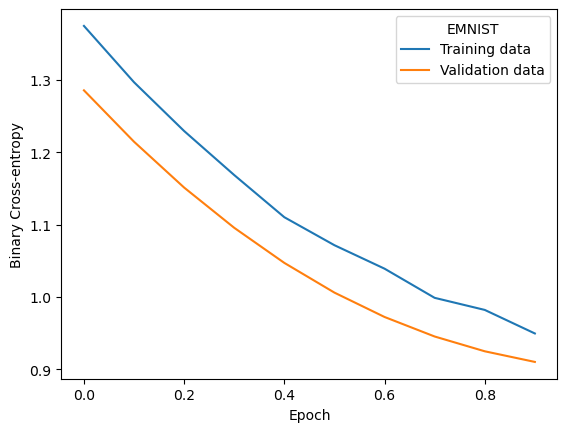

In [20]:
epoch = np.arange(len(losses))/n_blocks
plt.plot(epoch, losses, label='Training data')
plt.plot(epoch, validation_losses, label='Validation data')

plt.legend(title="EMNIST")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-entropy")

We can now place the inner loop developed above in a simpler outer loop, simply repeating the scan of the batches for a given number of times (or epochs).


In [21]:
losses = []
validation_losses = []
n_epochs = 20  ## <-- 🆕 We define the number of epochs
n_blocks = X_train.numblocks[0]

with trange(n_epochs*n_blocks, unit='updates') as progress_bar:
    for epoch in range(n_epochs):  ## <-- 🆕 We introduce a simple loop on the number of epochs
        for image_chunk, label_chunk in zip(X_train.blocks, y_train.blocks):
            progress_bar.update(1)
            loss = classifier.train_on_batch(image_chunk, label_chunk)
            losses.append(loss)
        
            validation_loss = classifier.test_on_batch(X_valid, y_valid)
            validation_losses.append(validation_loss)


100%|██████████| 200/200 [03:24<00:00,  1.02s/updates]


Text(0, 0.5, 'Binary Cross-entropy')

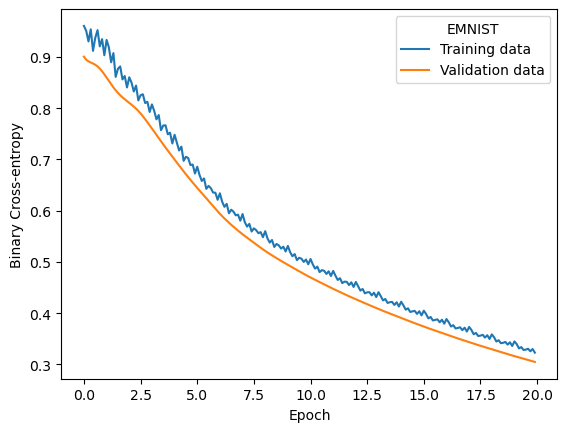

In [22]:
epoch = np.arange(len(losses))/n_blocks
plt.plot(epoch, losses, label='Training data')
plt.plot(epoch, validation_losses, label='Validation data')

plt.legend(title="EMNIST")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-entropy")

## Studying the performance of the algorithm

We are now ready to test the performance of the algorithm.

### Performance-measurement dataset (a.k.a. test dataset)
Whenever possible, one must use a dataset independent of the one used for training to estimate the performance of the algorithm

In this case, the splitting between training and validation samples was defined by the `emnist` Python package, and we can reuse their definition.

Let's load the test sample and apply the preprocessing steps to both the input images and the ground-truth labels.

In [23]:
emnist = tfds.load('mnist', split='test', as_supervised=True)

test_images = np.array([image for image, _ in tqdm(tfds.as_numpy(emnist), desc="Repacking images to numpy")]).reshape((-1, 28, 28))
test_labels = np.array([label for _, label in tqdm(tfds.as_numpy(emnist), desc="Repacking labels to numpy")])

X_test = da.from_array(test_images, chunks=(6000, -1, -1)).astype(np.float32)
X_test = X_test/255

y_test = test_labels > 0

Repacking labels to numpy: 100%|██████████| 10000/10000 [00:01<00:00, 5220.04it/s]


### Computing the predictions

We can either use the `.predict` method provided by keras (and let it deal with the division in batches) or we can make an explicit loop with `.predict_on_batch`.

As for the training, in this way the Dask pipeline is executed "on demand", block by block, when keras requires access to a particular chunk of data, which may significantly reduce the amount of memory needed to perform the computation (at the expense of a more-frequent access to disk).

In [24]:
predictions = np.concatenate([classifier.predict_on_batch(X) for X in X_test.blocks])
labels = y_test

### Histogram of the response

Let's fill a histogram with the response of the neural network, separate for the *zero* and *non-zero* categories.

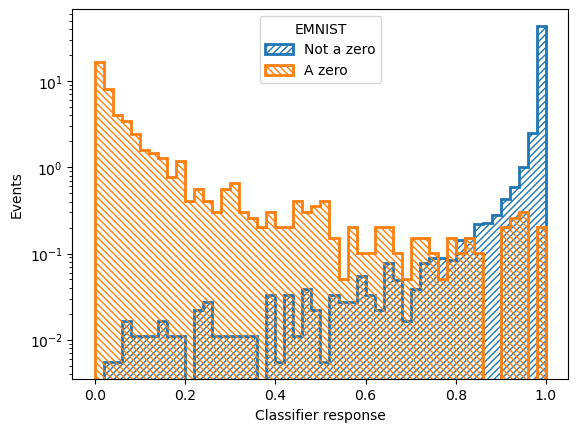

In [25]:
plt.hist(predictions[labels>0.5], bins=np.linspace(0, 1, 51), histtype='step', hatch='/'*5, linewidth=2, label="Not a zero", density=True)
plt.hist(predictions[labels<0.5], bins=np.linspace(0, 1, 51), histtype='step', hatch='\\'*5, linewidth=2, label="A zero", density=True)
plt.legend(title="EMNIST")
plt.xlabel("Classifier response")
plt.ylabel("Events")
plt.yscale('log')
plt.show()

### Displaying wrong classifications

It can be interesting to display some picures for which the classification was particularly wrong.
This might help to understand how to improve our model, or (more often) our preprocessing and feature engineering steps.

Here below we make an example of plotting the 9 "zero" pictures with the highest probability (estimated by our CNN) of being non-zero.

You can see they are all somehow bizarre, and probably under-represented in the training dataset. 

If we were trying to improve further the performance, we may try to increase the complexity of the CNN as this sounds like a case of under-fitting.

Also, in most figures there are white dots that are a residual from some imperfect preprocessing step (done by the maintainer of the EMNIST dataset). 

Cleaning these dots at preprocessing level  (for example filtering, or implemening some metrics that ignores too small white regions) may help the CNN to identify these pictures as zeros.

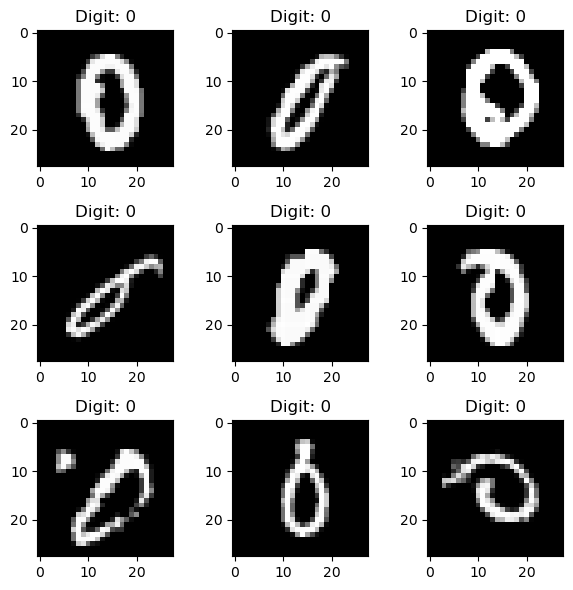

In [26]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import dask.array as da

selected_images = np.argsort(predictions[labels<0.5].flatten())[-9:]

plt.figure(figsize=(6, 6))
for iPlot, selected_image in enumerate(selected_images, 1):
    plt.subplot(3, 3, iPlot)
    plt.imshow(test_images[labels<0.5][selected_image], cmap='gray')
    plt.title(f"Digit: {test_labels[labels<0.5][selected_image]}")
plt.tight_layout()

### The ROC curve and the *Area Under the Curve* (ROC-AUC)

At the end, we can display the ROC curve and compute its integral, determining the *Area Under the Curve*, a commonly adopted metric for evaluating the performance of a binry classifier.

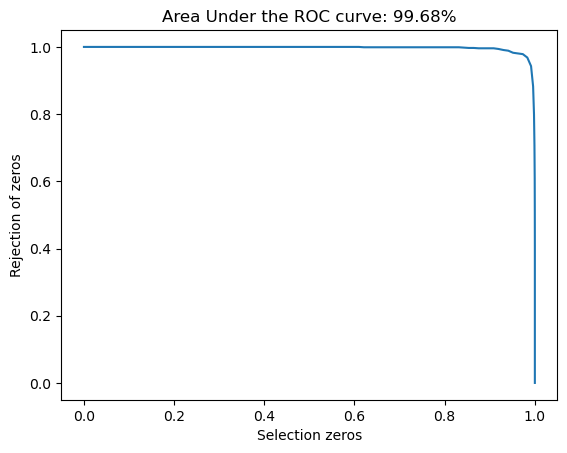

In [27]:
## We pick some meaningful threshold values, by using the quantile function of numpy
thresholds = np.quantile(predictions, np.linspace(0, 1, 101))

## We select the predictions associated to non-zero pictures by the ground-truth label.
non_zeros_y = predictions[labels>0.5]

## For each threshold, we count the fraction of non-zero picutres above that threshold
## This represents the "selection efficiency" of non-zero candidates.
non_zero_efficiency = np.array([np.count_nonzero(non_zeros_y > t) for t in thresholds])/len(non_zeros_y)


## Same thing for the zero picture. First we select them by cutting on the ground-truth.
zeros_y = predictions[labels<0.5]
## Then we comute the rejection (1-selection efficiency)
zeros_rejection = np.array([np.count_nonzero(zeros_y < t) for t in thresholds])/len(zeros_y)

## Finally we use the trapz function of numpy to compute the integral of the ROC curve
roc_auc = np.trapz(non_zero_efficiency, zeros_rejection)

## ..cosmetics...
plt.title (f"Area Under the ROC curve: {roc_auc*100.:.2f}%")
plt.plot(non_zero_efficiency, zeros_rejection)
plt.xlabel("Selection zeros")
plt.ylabel("Rejection of zeros")
plt.show()

## Serializing and Storing the model

You can finally store the model either in a directory (TensorFlow format) or in keras (Keras format). 

TensorFlow format should be more general and enable to store non-keras models (which we are not using in here), while keras should be more portable, enabling storing a model trained in TensorFlow and reload it in Torch, Jax or Theano. In practice, such portability of keras models is not guaranteed.

In this school, we prefer the keras format simply because it stores everything in single file.

To choose the keras format, just make sure the path you indicate in the `.save` method ends with `.keras`.

In [28]:
classifier.save("nonzeroness_classifier.keras")